In [26]:
import tensorflow as tf

In [27]:
from policy_eval.dataset import F110Dataset
import f110_gym
import f110_orl_dataset
import gymnasium as gym
# import the behavior dataset for normalization results
env = gym.make('f110_with_dataset-v0',
# only terminals are available as of right now 
    **dict(name='f110_with_dataset-v0',
        config = dict(map="Infsaal", num_agents=1,
        params=dict(vmin=0.5, vmax=2.0)),
            render_mode="human")
)

behavior_dataset = F110Dataset(
    env,
    normalize_states=True,
    normalize_rewards=True,
    noise_scale=0.0,
    bootstrap=True,
    debug=False,
    path = "/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr",
    exclude_agents = ['det'], #['td_progr'] +['min_acti'] + ['velocity'] + ['steering'] + ['vel_chan'] ,#+ ['raceline'], # ['min_lida'],
    scans_as_states=False,
    alternate_reward=True,)

{'config': {'map': 'Infsaal', 'num_agents': 1, 'params': {'vmin': 0.5, 'vmax': 2.0}}, 'render_mode': 'human'}
hi
===
Box([[-0.4189 -5.    ]], [[ 0.4189 20.    ]], (1, 2), float32)
low
20
Box([-30.        -30.         -6.2831855 -20.        -20.        -20.
  -0.4189      0.7         0.       ], [30.        30.         6.2831855 20.        20.        20.
  0.4189     2.         1.       ], (9,), float32)
***********
/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr


/mnt/hdd2/fabian/f1tenth_dope/f1tenth_gym/gym/f110_gym/envs/integrator.py:13: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(
/mnt/hdd2/fabian/miniconda3/envs/f110/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


['det' 'min_acti' 'min_lida' 'raceline' 'steering' 'td_progr' 'vel_chan'
 'velocity']
len(model_names) 352236
Indices: 352232
Using alternate reward
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_theta
poses_x
poses_y
previous_action
progress
Number of timesteps: 352232
dict_keys(['rewards', 'terminals', 'timeouts', 'actions', 'log_probs', 'index', 'observations', 'scans', 'infos'])
Added trajectory 600 with length 720.
tf.Tensor(
[[-0.7099139   0.03920106  2.7189848   0.01344078  0.13866381  0.
   0.          0.7         0.00845972]
 [-0.7194685   0.04317873  2.7206464   0.0524216   0.27024296  0.
   0.02134451  0.75        0.00889027]], shape=(2, 9), dtype=float32)


In [28]:
bhv = behavior_dataset.initial_weights.numpy()


In [29]:
import numpy as np

In [30]:
print(len(bhv))
print(np.sum(bhv))
print(bhv[:30])

762
762.0
[2. 1. 1. 0. 3. 1. 1. 3. 2. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 2. 0. 1. 1. 2.]


In [31]:
evalutation_ds = env.get_dataset(zarr_path="/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/evaluation_ds.zarr", 
                    alternate_reward = False,
                    remove_short_trajectories=False,
                    split_trajectories=0,
                    skip_inital=0)

/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/evaluation_ds.zarr
['evaluation']
len(model_names) 975
Indices: 975
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_theta
poses_x
poses_y
previous_action
progress
Number of timesteps: 975


In [32]:

print(evalutation_ds["observations"][:2])

[[-4.6471705  -1.5         0.          0.          0.12941957  0.
   0.          0.7         0.10425393]
 [-4.6471705  -1.2         0.          0.          0.12941957  0.
   0.          0.7         0.10425393]]


In [33]:
from policy_eval.q_fitter import QFitter
# load the model
model =  QFitter(behavior_dataset.states.shape[1],#env.observation_spec().shape[0],
                    env.action_spec().shape[1], 0.0, 0.0,
                    0.0) # lr, weight_decay, tau irrelevatn
model.load("/mnt/hdd2/fabian/f1tenth_dope/ws_ope/logdir/td_progr/fqe_model_190000")

/mnt/hdd2/fabian/miniconda3/envs/f110/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


/mnt/hdd2/fabian/miniconda3/envs/f110/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [34]:
import numpy as np
# import stable_baselines3 as sb3
#from f110_orl_dataset.normalize_dataset import Normalize
#from f110_orl_dataset.dataset_agents import F110Actor
#target_policy = "td_progr"
#actor = F110Actor(target_policy, deterministic=False) #F110Stupid()
#model_input_normalizer = Normalize()

def get_target_actions(states, scans= None, batch_size=5000):
    """
    num_batches = int(np.ceil(len(states) / batch_size))
    actions_list = []
    # batching, s.t. we dont run OOM
    for i in range(num_batches):
      start_idx = i * batch_size
      end_idx = min((i + 1) * batch_size, len(states))
      batch_states = states[start_idx:end_idx]

      # unnormalize from the dope dataset normalization
      batch_states_unnorm = behavior_dataset.unnormalize_states(batch_states) # this needs batches
      batch_states_unnorm = batch_states_unnorm.numpy()

      # get scans
      if scans is not None:
        laser_scan = scans[start_idx:end_idx]
      else:
        laser_scan = env.get_laser_scan(batch_states_unnorm, 20) # TODO! rename f110env to dataset_env
        laser_scan = model_input_normalizer.normalize_laser_scan(laser_scan)

      # back to dict
      model_input_dict = model_input_normalizer.unflatten_batch(batch_states_unnorm)
      # normalize back to model input
      model_input_dict = model_input_normalizer.normalize_obs_batch(model_input_dict)
     
      # now also append the laser scan
      model_input_dict['lidar_occupancy'] = laser_scan

      batch_actions = actor(
        model_input_dict, std=0.0)[1]
      
      actions_list.append(batch_actions)

    actions = tf.concat(actions_list, axis=0)
    actions = tf.convert_to_tensor(actions)
    """
    #actions = states[:,-3:-1]
    # print(actions[2])
    actions = np.zeros((len(states), 2), dtype=np.float32)
    #actions[:,0] = 0.5
    #actions[:,1] = 1.0 
    return actions

In [35]:
inital_weights = tf.convert_to_tensor(np.ones(len(evalutation_ds["observations"]),dtype=np.float32))

In [36]:
# normalize observations according to behavior dataset
print(evalutation_ds["observations"].shape)
print(evalutation_ds["observations"][:2])
normalized_obs = behavior_dataset.normalize_states(evalutation_ds["observations"])
normalized_obs = tf.convert_to_tensor(normalized_obs)
print(normalized_obs.shape)
print(normalized_obs[:2])

(975, 9)
[[-4.6471705  -1.5         0.          0.          0.12941957  0.
   0.          0.7         0.10425393]
 [-4.6471705  -1.2         0.          0.          0.12941957  0.
   0.          0.7         0.10425393]]
(975, 9)
tf.Tensor(
[[-1.889335   -1.8524445  -1.7465777   0.379201   -1.696939    0.
   0.4280744  -0.65389013 -1.3526711 ]
 [-1.889335   -1.7478404  -1.7465777   0.379201   -1.696939    0.
   0.4280744  -0.65389013 -1.3526711 ]], shape=(2, 9), dtype=float32)


In [37]:
returns = model.estimate_returns_unweighted(normalized_obs, get_target_actions)

In [38]:
import matplotlib.pyplot as plt
import numpy as np
def plot_reward_heatmap(normalized_obs, rewards, bins=10):
    """
    Plots a heatmap-like visualization of average rewards based on binned x, y coordinates.

    Args:
    - normalized_obs (np.array): Array with shape (len, 9) where (:,0) is x and (:,1) is y.
    - rewards (np.array): Array with rewards of same length as normalized_obs.
    - bins (int or list): Number of bins or a list of bin edges for the histogram.
    """
    
    # Bin the x and y coordinates
    x_bins = np.linspace(normalized_obs[:,0].min(), normalized_obs[:,0].max(), bins)
    y_bins = np.linspace(normalized_obs[:,1].min(), normalized_obs[:,1].max(), bins)
    
    bin_indices = np.digitize(normalized_obs[:,0], x_bins) - 1
    bin_jndices = np.digitize(normalized_obs[:,1], y_bins) - 1
    
    reward_map = np.zeros((bins, bins))
    count_map = np.zeros((bins, bins))
    
    for i, j, reward in zip(bin_indices, bin_jndices, rewards):
        # print(i,j,reward)
        reward_map[i, j] += reward
        count_map[i, j] += 1
    
    # Avoid division by zero
    count_map[count_map == 0] = 1
    avg_reward_map = reward_map / count_map
    
    plt.imshow(avg_reward_map, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])#,vmin=-0.1, vmax=0.1)
    plt.colorbar(label='Average Reward')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Average Reward Heatmap')
    plt.show()


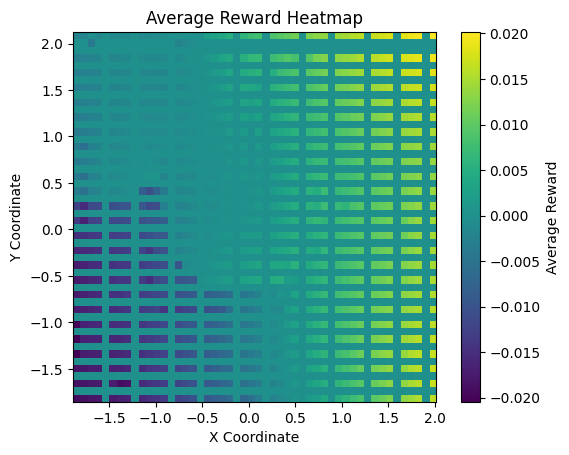

In [39]:
plot_reward_heatmap(normalized_obs.numpy(), returns.numpy(), bins=50)

In [40]:
returns_behav = model.estimate_returns_unweighted(behavior_dataset.states, get_target_actions)

In [41]:
def get_target_actions(states, scans= None, batch_size=5000):
    actions = np.zeros((len(states), 2), dtype=np.float32)
    return actions
def get_target_actions1(states, scans= None, batch_size=5000):
    actions = np.zeros((len(states), 2), dtype=np.float32)
    actions[:,0] = 0.5
    actions[:,1] = 1.0
    return actions

def get_target_actions2(states, scans= None, batch_size=5000):
    actions = np.zeros((len(states), 2), dtype=np.float32)
    actions[:,0] = 0.0
    actions[:,1] = - 1.0
    return actions

def get_target_actions3(states, scans= None, batch_size=5000):
    actions = np.zeros((len(states), 2), dtype=np.float32)
    actions[:,0] = 1.0
    actions[:,1] = - 1.0
    return actions
def get_target_actions4(states, scans= None, batch_size=5000):
    actions = states[:,-3:-1]
    return actions

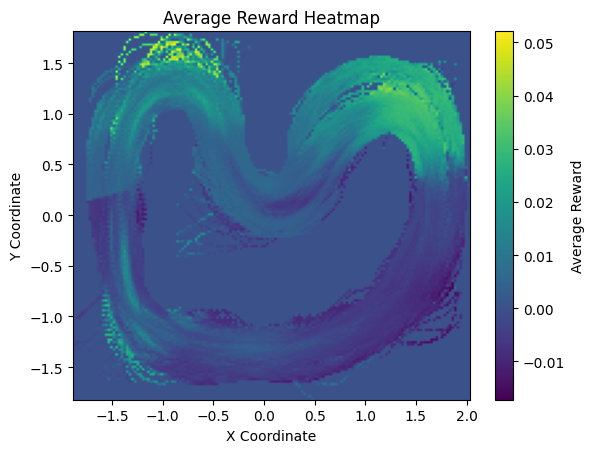

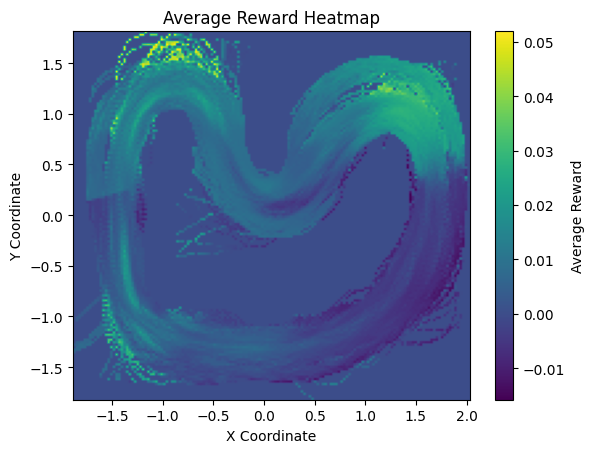

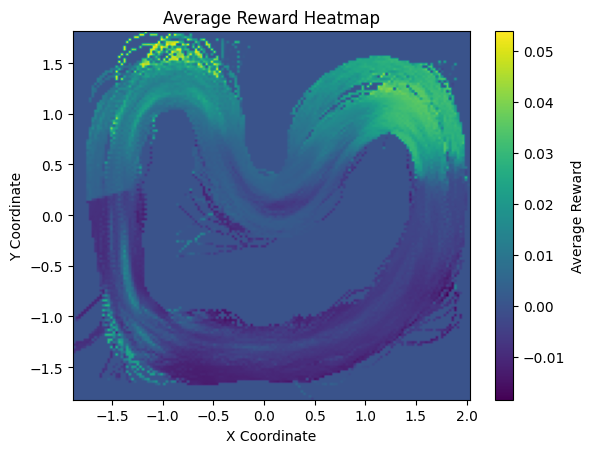

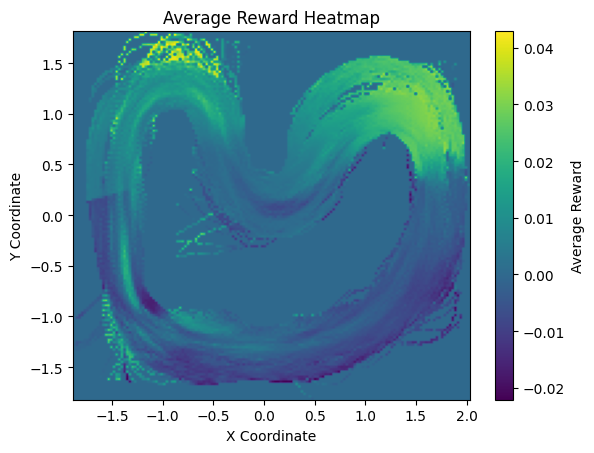

In [24]:

behav = model.estimate_returns_unweighted(behavior_dataset.states, get_target_actions)
plot_reward_heatmap(behavior_dataset.states.numpy(), behav.numpy(), bins=150)


behav = model.estimate_returns_unweighted(behavior_dataset.states, get_target_actions1)
plot_reward_heatmap(behavior_dataset.states.numpy(), behav.numpy(), bins=150)


behav = model.estimate_returns_unweighted(behavior_dataset.states, get_target_actions2)
plot_reward_heatmap(behavior_dataset.states.numpy(), behav.numpy(), bins=150)


behav = model.estimate_returns_unweighted(behavior_dataset.states, get_target_actions3)
plot_reward_heatmap(behavior_dataset.states.numpy(), behav.numpy(), bins=150)
behav = model.estimate_returns_unweighted(behavior_dataset.states, get_target_actions3)
plot_reward_heatmap(behavior_dataset.states.numpy(), behav.numpy(), bins=150)

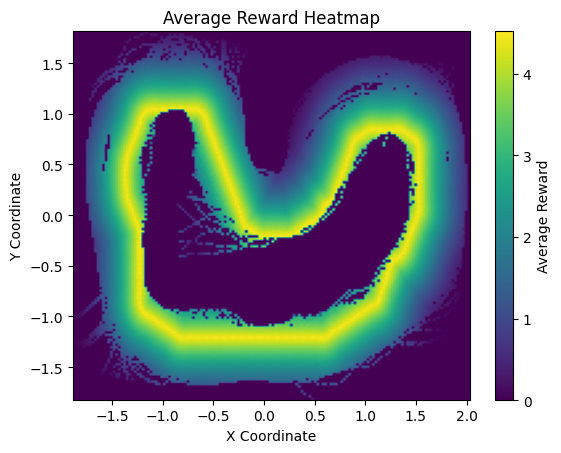

In [19]:
plot_reward_heatmap(behavior_dataset.states.numpy(), behavior_dataset.rewards.numpy(), 
                    bins=150)


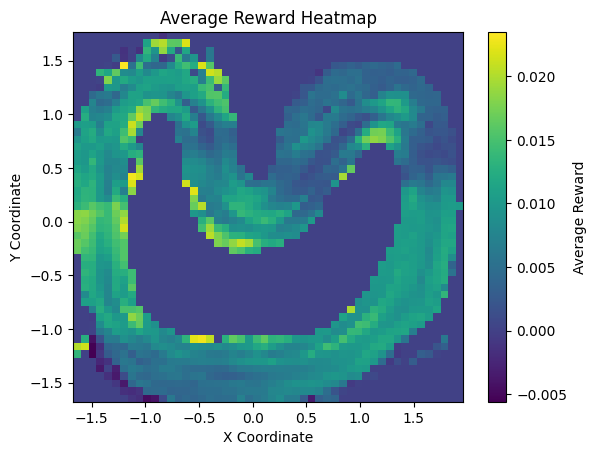

In [46]:
plot_reward_heatmap(behavior_dataset.states.numpy(), returns_behav.numpy(), bins=50)

In [23]:
returns.numpy()

[0.01793408 0.01754965 0.01722687 0.01698611 0.01643679 0.01590016
 0.0152551  0.01468536 0.01396364 0.01320066 0.01277953 0.01261445
 0.01240454 0.01226033 0.01213525 0.0119512  0.01208682 0.01245414
 0.0143032  0.014753   0.01326397 0.01371964 0.01441411 0.01468736
 0.01503061 0.01555467 0.01720277 0.01736163 0.01897277 0.0195152
 0.02003309 0.02037378 0.01985871 0.02012583 0.02052725 0.02099194
 0.02155647 0.02207157 0.02247181 0.01834196 0.0179489  0.01769646
 0.0174509  0.01699041 0.01641464 0.01598711 0.0150036  0.01428987
 0.01360874 0.01311868 0.01292243 0.01277761 0.01251926 0.01225778
 0.0119484  0.01190134 0.01216077 0.0124561  0.01261151 0.0126991
 0.01294427 0.01340587 0.01386469 0.01433593 0.01494869 0.01593012
 0.01674997 0.01736066 0.01806983 0.01837699 0.01866738 0.01901875
 0.01928305 0.01968233 0.02076376 0.0205269  0.02107514 0.02161628
 0.01883086 0.0184388  0.01806944 0.01768067 0.01705479 0.01647908
 0.01591315 0.01537253 0.01479576 0.01414579 0.0135802  0.013156

In [88]:
logdir = "logdir/f110_rl_50_0_9_/"
# Get all directories inside the logdir
all_folders = [d for d in os.listdir(logdir) if os.path.isdir(os.path.join(logdir, d))]

In [89]:
# Function to extract target_policy from folder name
def get_target_policy(folder_name):
    for part in folder_name.split(","):
        key, value = part.split("=")
        if key == "target_policy":
            return value
    return None


In [90]:
def get_dict(tag="train/pred returns"):
    # Dictionary to store returns
    all_returns = {}

    for folder in all_folders:
        dir_path = os.path.join(logdir, folder)
        
        # We'll assume there's only one file per directory as in your code. 
        # If there are multiple files, this will take the first file found.
        file_path = os.path.join(dir_path, os.listdir(dir_path)[0])
        
        target_policy = get_target_policy(folder)
        
        returns = []
        for e in summary_iterator(file_path):    
            for v in e.summary.value:
                if v.tag == tag:            
                    returns.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        # Append returns to the respective key in the dictionary
        if target_policy in all_returns:
            all_returns[target_policy].append(returns)
        else:
            all_returns[target_policy] = [returns]
    return all_returns


In [91]:
import numpy as np
def compute_statistics(data):
    """
    Compute mean and standard deviation for each list across the outer list.
    
    Args:
    - data (list of lists): Input data where inner lists contain numbers.

    Returns:
    - means (list): Mean of each list across the outer list.
    - std_devs (list): Standard deviation of each list across the outer list.
    """
    # Convert to numpy array for easier calculations
    np_data = np.array(data)
    
    # If the inner lists aren't of equal length, this will raise a ValueError
    means = np_data.mean(axis=0).tolist()
    std_devs = np_data.std(axis=0).tolist()
    
    return means, std_devs

In [92]:
all_returns_dr = get_dict(tag="train/pred returns")
std_fqe = get_dict(tag="std_deviation returns (fqe)")
mean_fqe = get_dict(tag="train/pred returns (fqe)")


In [95]:
def compute_means_std(policy_returns):
    computed_means = {}
    computed_std_devs = {}
    for target_policy, returns in policy_returns.items():
        means, std_devs = compute_statistics(returns)
        computed_means[target_policy] = means
        computed_std_devs[target_policy] = std_devs
    for target_policy in computed_means.keys():
        computed_means[target_policy] = np.mean(np.array(computed_means[target_policy])[len(computed_means[target_policy])//2:])
        computed_std_devs[target_policy] = np.mean(np.array(computed_std_devs[target_policy][len(computed_std_devs[target_policy])//2:]))
    return computed_means, computed_std_devs

In [97]:
all_returns_dr_means, all_returns_dr_std_devs = compute_means_std(all_returns_dr)
std_fqe_means, std_fqe_std_devs = compute_means_std(std_fqe)
mean_fqe_means, mean_fqe_std_devs = compute_means_std(mean_fqe)
print(mean_fqe_means)

{'velocity': 0.545027619600296, 'min_lida': 0.5580434620380401, 'raceline': 0.523678970336914, 'min_acti': 0.5827798068523407, 'td_progr': 0.5242257237434387, 'steering': 0.5569152891635895, 'vel_chan': 0.5769457936286926}


In [98]:
# For example usage:
for target_policy, returns in std_fqe.items():
    means, std_devs = compute_statistics(returns)
    print(f"For {target_policy}:")
    print(f"Means: {means}")
    print(f"Standard Deviations: {std_devs}")
    print("------")

For velocity:
Means: [0.0024581237230449915, 0.07626109570264816, 0.08194440603256226, 0.08417685329914093, 0.08731166273355484, 0.08911065012216568, 0.0926123559474945, 0.09503400325775146, 0.0980219691991806, 0.10059527307748795, 0.10290956497192383, 0.10483768582344055, 0.10740657895803452, 0.10958091169595718, 0.11080484837293625, 0.11263900250196457, 0.11263828724622726, 0.11454251408576965, 0.11618367582559586, 0.11755304783582687]
Standard Deviations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
------
For min_lida:
Means: [0.0023766818922013044, 0.06867606192827225, 0.07599738985300064, 0.08442835509777069, 0.08922058343887329, 0.09430661052465439, 0.09717531502246857, 0.09870877861976624, 0.1015094667673111, 0.10548283904790878, 0.10621726512908936, 0.10914988815784454, 0.11066974699497223, 0.11206437647342682, 0.11331650614738464, 0.1160588338971138, 0.11785964667797089, 0.1192735880613327, 0.1206369623541832, 0.12152550

In [99]:
all_returns = get_dict()
print(all_returns.keys())
print(all_returns["min_acti"])


dict_keys(['velocity', 'min_lida', 'raceline', 'min_acti', 'td_progr', 'steering', 'vel_chan'])
[[0.7324164509773254, 0.7375397682189941, 0.7316747903823853, 0.7265916466712952, 0.723294198513031, 0.7203970551490784, 0.7216131687164307, 0.7179529070854187, 0.7196685671806335, 0.7187087535858154, 0.7170130014419556, 0.7212874293327332, 0.7195682525634766, 0.7198764085769653, 0.7218990921974182, 0.7227324843406677, 0.7170342803001404, 0.7194188833236694, 0.7177678942680359, 0.7156828045845032], [0.7324164509773254, 0.7375397682189941, 0.7316747903823853, 0.7265916466712952, 0.723294198513031, 0.7203970551490784, 0.7216131687164307, 0.7179529070854187, 0.7196685671806335, 0.7187087535858154, 0.7170130014419556, 0.7212874293327332, 0.7195682525634766, 0.7198764085769653, 0.7218990921974182, 0.7227324843406677, 0.7170342803001404, 0.7194188833236694, 0.7177678942680359, 0.7156828045845032]]


In [100]:
import numpy as np
import matplotlib.pyplot as plt

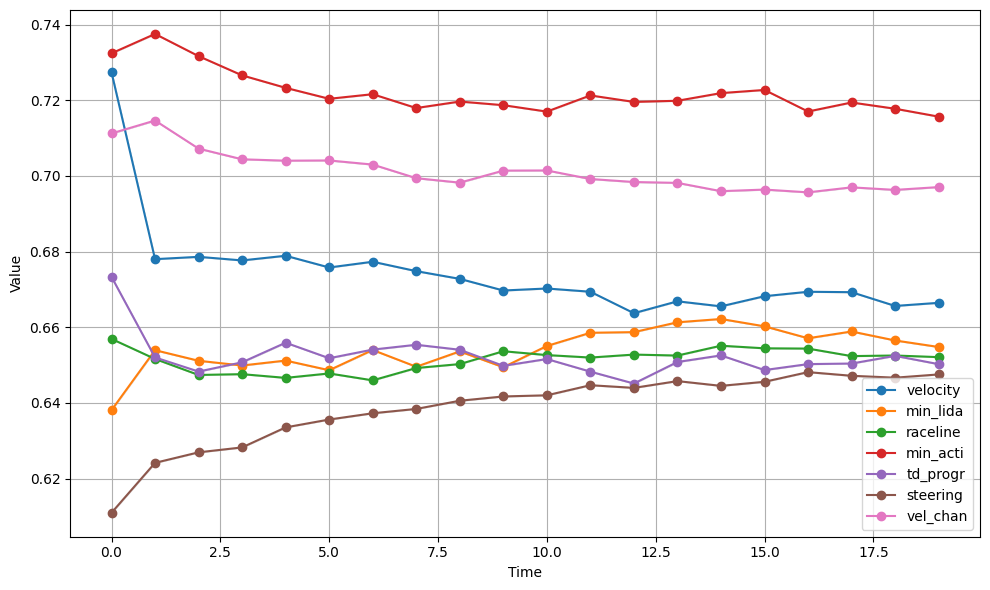

In [101]:
# The function to plot the data
def plot_data(policy, means, std_devs):
    x = list(range(len(means)))
    
    
    plt.plot(x, means, label=f"{policy}", marker='o')
    plt.fill_between(x, np.array(means) - np.array(std_devs), 
                     np.array(means) + np.array(std_devs), color='gray', alpha=0.2)
    #plt.le

# Loop through your data and plot
plt.figure(figsize=(10, 6))
computed_means = {}
computed_std_devs = {}
for target_policy, returns in all_returns.items():
    means, std_devs = compute_statistics(returns)
    computed_means[target_policy] = means
    computed_std_devs[target_policy] = std_devs
    plot_data(target_policy, means, std_devs)
    
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [102]:
print(computed_means)

{'velocity': [0.7274020910263062, 0.678006649017334, 0.6786226034164429, 0.6776729822158813, 0.6789067387580872, 0.6758053302764893, 0.677322506904602, 0.6748397350311279, 0.6727980971336365, 0.6697215437889099, 0.6702516078948975, 0.669396698474884, 0.6637260913848877, 0.666864275932312, 0.6655338406562805, 0.6682156920433044, 0.6693853139877319, 0.6692773103713989, 0.6656401753425598, 0.6664634346961975], 'min_lida': [0.6380959749221802, 0.653948187828064, 0.6511458158493042, 0.6498953104019165, 0.6511989831924438, 0.6486502289772034, 0.6539981961250305, 0.6495672464370728, 0.6536279320716858, 0.649437665939331, 0.655055046081543, 0.6585474014282227, 0.6587178111076355, 0.6613157391548157, 0.6621907949447632, 0.6602498292922974, 0.6570982336997986, 0.6588860750198364, 0.6565101146697998, 0.6547899842262268], 'raceline': [0.6569287776947021, 0.6516295671463013, 0.6473965048789978, 0.6476061344146729, 0.6466246247291565, 0.6477971076965332, 0.6459680795669556, 0.6492311954498291, 0.650

In [103]:
# caluclate the original means from the dataset
import f110_gym
import f110_orl_dataset
import gymnasium as gym
# import gymnasium as gym
F110Env = gym.make('f110_with_dataset-v0',
    # only terminals are available as of tight now 
        **dict(name='f110_with_dataset-v0',
            config = dict(map="Infsaal", num_agents=1),
              render_mode="human")
    )
root = F110Env.get_dataset(zarr_path="/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr",
                            skip_inital=50,
                            split_trajectories=50,
                            alternate_reward=True,
                            remove_short_trajectories=True)
def get_change_indices(model_names):
    change_indices = []
    current_name = model_names[0]
    for idx, name in enumerate(model_names):
        if name != current_name:
            change_indices.append(idx)
            current_name = name
    return change_indices
model_names = root["infos"]["model_name"]
change_indices = get_change_indices(model_names) + [len(model_names)]
print(change_indices)


{'config': {'map': 'Infsaal', 'num_agents': 1}, 'render_mode': 'human'}


/mnt/hdd2/fabian/f1tenth_dope/f1tenth_gym/gym/f110_gym/envs/integrator.py:13: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(


hi
===
Box([[-0.4189 -5.    ]], [[ 0.4189 20.    ]], (1, 2), float32)
low
20
Box([-30.        -30.         -6.2831855 -20.        -20.        -20.
  -0.4189      0.7         0.       ], [30.        30.         6.2831855 20.        20.        20.
  0.4189     2.         1.       ], (9,), float32)
***********
/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr
['det' 'min_acti' 'min_lida' 'raceline' 'steering' 'td_progr' 'vel_chan'
 'velocity']
len(model_names) 352236
Indices: 352236
Using alternate reward
ang_vels_z
lidar_occupancy


/mnt/hdd2/fabian/miniconda3/envs/f110/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


linear_vels_x
linear_vels_y
poses_theta
poses_x
poses_y
previous_action
progress
Number of timesteps: 296100
[35400, 80900, 126150, 162250, 207100, 250500, 296100]


In [104]:
def calculate_discounted_reward(rewards, done, truncated, gamma=0.99):
    # combine done and truncated
    done_or_truncated = np.logical_or(done, truncated)
    # split into segments at done or truncated
    change_indices = np.where(done_or_truncated)[0] + 1 # catch the last segment
    # ensure that we dont access out of bounds, by checking if we are at the end
    change_indices[-1] = min(change_indices[-1], len(rewards)-1)
    # calculate discounted reward for each segment
    start_idx = 0
    discounted_rewards = []
    for end_idx in change_indices:
        segment_rewards = rewards[start_idx:end_idx]
        #print(len(segment_rewards))
        discounted_reward = np.sum(segment_rewards * gamma ** np.arange(len(segment_rewards)))
        # print(f'Discounted reward: {discounted_reward}')
        discounted_rewards.append(discounted_reward)
        start_idx = end_idx
    return np.mean(discounted_rewards), np.std(discounted_rewards)

In [105]:
# for each model the number of ored dones and truncates
print("Number of ores done and truncates for each model:")
done = root['timeouts']
truncated = root['terminals']
done_or_truncated = np.logical_or(done, truncated)
start_idx = 0
# print("Discounted TD Reward")
for idx, change_idx in enumerate(change_indices):
    # count number of collisions for this model
    num_done_or_truncated = np.sum(done_or_truncated[start_idx:change_idx])
    print(f'{model_names[start_idx]}: {num_done_or_truncated}')
    start_idx = change_idx

Number of ores done and truncates for each model:
velocity: 708
raceline: 910
min_lida: 905
td_progr: 722
steering: 897
min_acti: 868
vel_chan: 912


In [106]:
# for each model calculate the mean discounted reward
start_idx = 0
print("Discounted TD Reward")
gamma = 0.9
precomputed_returns = { model_names[start_idx]: [] for start_idx in change_indices[:-1]}
precomputed_stds = { model_names[start_idx]: [] for start_idx in change_indices[:-1]}
means = []
stds = []
# model_names_.append(model_names[start_idx])
for idx, change_idx in enumerate(change_indices): # this is for each model
    # count number of collisions for this model
    try:
        mean_discounted_reward, std_discounted = calculate_discounted_reward(root['rewards'][start_idx:change_idx],
                                    root['terminals'][start_idx:change_idx],
                                    root['timeouts'][start_idx:change_idx], gamma=gamma)
        print(f'{model_names[start_idx]}: {mean_discounted_reward} +- {std_discounted} ({mean_discounted_reward* (1-gamma)} +- {std_discounted * (1-gamma)})')
        means.append(mean_discounted_reward* (1-gamma))
        stds.append(std_discounted* (1-gamma))
        precomputed_returns[model_names[start_idx]] = mean_discounted_reward* (1-gamma)
        precomputed_stds[model_names[start_idx]] = std_discounted* (1-gamma)
        start_idx = change_idx
        
    except:
        print(0)


Discounted TD Reward
velocity: 6.5593316786717235 +- 1.287364232186607 (0.6559331678671722 +- 0.12873642321866066)
raceline: 8.787580013451317 +- 0.6515950258394945 (0.8787580013451315 +- 0.06515950258394944)
min_lida: 6.293978870657342 +- 1.348448672829259 (0.6293978870657341 +- 0.13484486728292588)
td_progr: 7.9839733656286205 +- 1.0572131818971748 (0.7983973365628618 +- 0.10572131818971746)
steering: 6.570256638270102 +- 1.6199262629224793 (0.6570256638270101 +- 0.1619926262922479)
min_acti: 4.407767473063719 +- 2.0599842650723303 (0.4407767473063718 +- 0.205998426507233)
vel_chan: 5.140409218496693 +- 1.3631803411191254 (0.5140409218496692 +- 0.1363180341119125)


In [107]:
print(precomputed_returns)
print(precomputed_stds)
print(computed_means)
print(computed_std_devs)

{'raceline': 0.8787580013451315, 'min_lida': 0.6293978870657341, 'td_progr': 0.7983973365628618, 'steering': 0.6570256638270101, 'min_acti': 0.4407767473063718, 'vel_chan': 0.5140409218496692, 'velocity': 0.6559331678671722}
{'raceline': 0.06515950258394944, 'min_lida': 0.13484486728292588, 'td_progr': 0.10572131818971746, 'steering': 0.1619926262922479, 'min_acti': 0.205998426507233, 'vel_chan': 0.1363180341119125, 'velocity': 0.12873642321866066}
{'velocity': [0.7274020910263062, 0.678006649017334, 0.6786226034164429, 0.6776729822158813, 0.6789067387580872, 0.6758053302764893, 0.677322506904602, 0.6748397350311279, 0.6727980971336365, 0.6697215437889099, 0.6702516078948975, 0.669396698474884, 0.6637260913848877, 0.666864275932312, 0.6655338406562805, 0.6682156920433044, 0.6693853139877319, 0.6692773103713989, 0.6656401753425598, 0.6664634346961975], 'min_lida': [0.6380959749221802, 0.653948187828064, 0.6511458158493042, 0.6498953104019165, 0.6511989831924438, 0.6486502289772034, 0.65

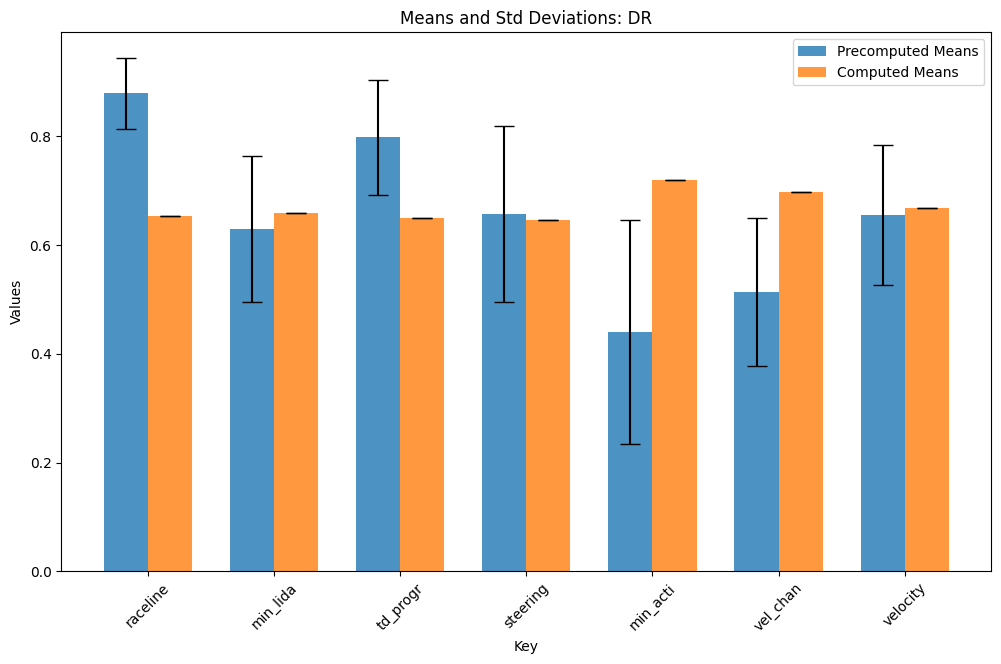

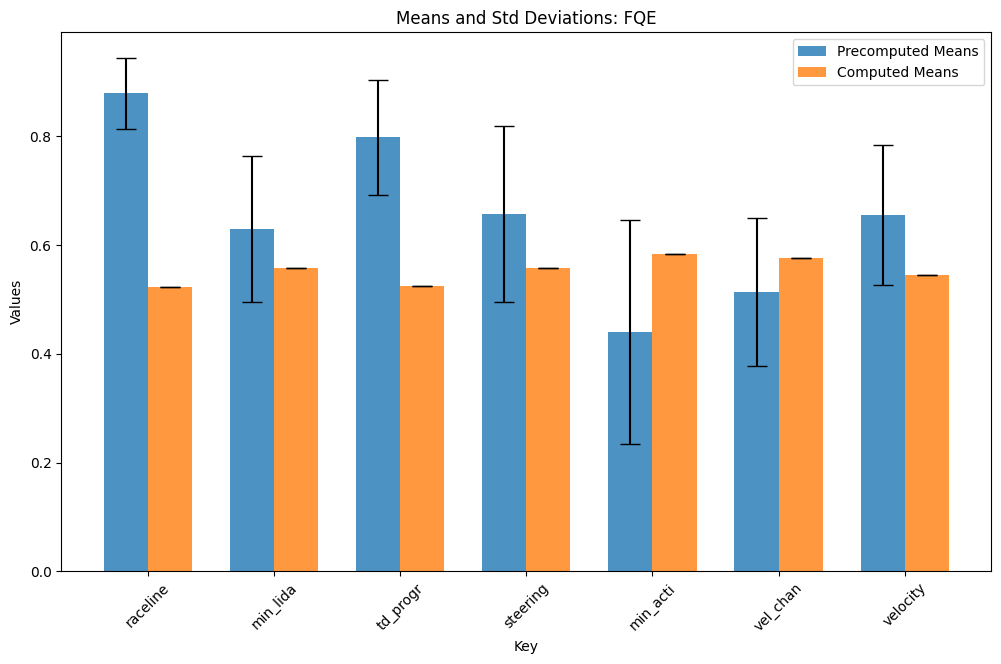

In [109]:
def plot_bar_vs(precomputed_returns, precomputed_stds, computed_means, computed_std_devs ,name = "DR"):
    # Assuming the order of precomputed_returns as the standard order
    keys = list(precomputed_returns.keys())
    precomputed_means_values = [precomputed_returns[key] for key in keys]
    precomputed_std_values = [precomputed_stds[key] for key in keys]
    computed_means_values = [computed_means[key] for key in keys]
    computed_std_values = [computed_std_devs[key] for key in keys]

    bar_width = 0.35
    index = np.arange(len(keys))

    fig, ax = plt.subplots(figsize=(12, 7))
    bar1 = ax.bar(index, precomputed_means_values, bar_width, yerr=precomputed_std_values, label='Precomputed Means', alpha=0.8, capsize=7)
    bar2 = ax.bar(index + bar_width, computed_means_values, bar_width, yerr=computed_std_values, label='Computed Means', alpha=0.8, capsize=7)

    ax.set_xlabel('Key')
    ax.set_ylabel('Values')
    ax.set_title(f"Means and Std Deviations: {name}")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(keys, rotation=45)
    ax.legend()

    plt.show()
plot_bar_vs(precomputed_returns, precomputed_stds, all_returns_dr_means, all_returns_dr_std_devs, name = "DR")
plot_bar_vs(precomputed_returns, precomputed_stds, mean_fqe_means, mean_fqe_std_devs, name = "FQE")

In [110]:
def compute_trajectory_lengths(done, truncated):
    done_or_truncated = np.logical_or(done, truncated)
    # Add an ending point to ensure the last trajectory is considered
    # done_or_truncated = np.append(done_or_truncated, [1])
    lengths = []
    count = 0
    for flag in done_or_truncated:
        if flag:
            lengths.append(count + 1)
            count = 0
        else:
            count += 1
    return lengths

Statistics for each model:
velocity:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 35400

raceline:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45500

min_lida:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45250

td_progr:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 36100

steering:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 44850

min_acti:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 43400

vel_chan:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45600

7
7
7


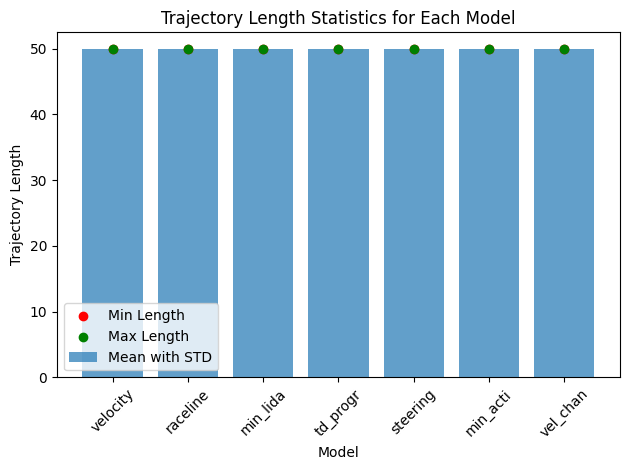

In [111]:
done = root['terminals']
truncated = root['timeouts']

start_idx = 0

# Lists for plotting
means = []
std_devs = []
mins = []
maxs = []

print("Statistics for each model:")
for idx, change_idx in enumerate(change_indices):
    current_lengths = compute_trajectory_lengths(done[start_idx:change_idx], truncated[start_idx:change_idx])

    mean_length = np.mean(current_lengths)
    std_dev = np.std(current_lengths)
    min_length = np.min(current_lengths)
    max_length = np.max(current_lengths)
    total_length = np.sum(current_lengths)
    print(f"{model_names[start_idx]}:")
    print(f"\tMean Length: {mean_length}")
    print(f"\tStandard Deviation: {std_dev}")
    print(f"\tMin Length: {min_length}")
    print(f"\tMax Length: {max_length}\n")
    print(f"\tTotal Length: {total_length}\n")
    # Add values to lists for plotting
    means.append(mean_length)
    std_devs.append(std_dev)
    mins.append(min_length)
    maxs.append(max_length)

    start_idx = change_idx

# Plotting
model_names_ = [model_names[i-1] for i in change_indices]
x = np.arange(len(np.unique(model_names)))
print(len(means))
print(len(std_devs))
print(len(x))
plt.bar(x, means, yerr=std_devs, label='Mean with STD', alpha=0.7)
plt.scatter(x, mins, color='red', label='Min Length', zorder=3)
plt.scatter(x, maxs, color='green', label='Max Length', zorder=3)

plt.xlabel('Model')
plt.ylabel('Trajectory Length')
plt.title('Trajectory Length Statistics for Each Model')
plt.xticks(x, model_names_, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Ordered Labels: ['raceline', 'min_lida', 'steering', 'td_progr', 'vel_chan', 'velocity', 'min_acti']
Ordered Means: [0.14693630769584384, 0.13479107013426772, 0.12017761282623063, 0.2941828878329745, 0.12726945278806082, 0.2836946103188693, 0.12713445333412188]
Ordered Std Devs: [0.0037664995471581113, 0.0113000199172739, 0.038079786959319344, 0.03408144002072949, 0.017277547870319026, 0.032016914931346015, 0.026519369818428628]


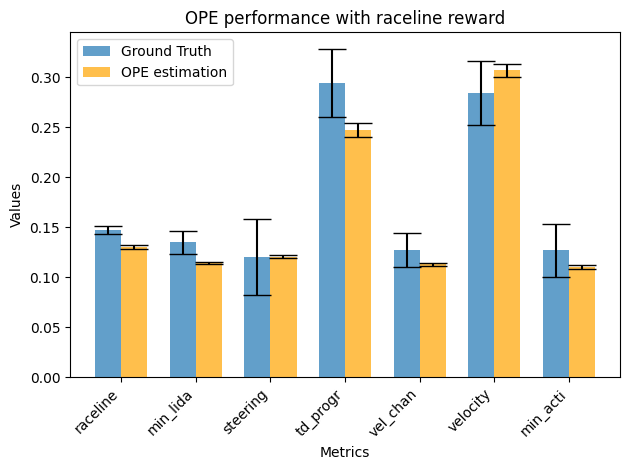

In [24]:
ordered_labels = ope_names
# Using a mapping dictionary to easily reorder the data
mapping = {label: (mean, std_dev) for label, mean, std_dev in zip(labels, original_means, original_std_devs)}

# Rearrange the means and std_devs to the new order
original_means = [mapping[label][0] for label in ordered_labels]
original_std_devs = [mapping[label][1] for label in ordered_labels]
print("Ordered Labels:", ordered_labels)
print("Ordered Means:", original_means)
print("Ordered Std Devs:", original_std_devs)

new_means = ope_means  # Replace with other means as needed
new_std_devs = ope_stds  # Replace with other std devs as needed

# Plotting
bar_width = 0.35
index = np.arange(len(labels))

# Plotting original data bars
plt.bar(index, original_means, bar_width, yerr=original_std_devs, align='center', alpha=0.7, 
        ecolor='black', capsize=10, label='Ground Truth')

# Plotting new data bars (shifted by bar_width for non-overlapping)
plt.bar(index + bar_width, new_means, bar_width, yerr=new_std_devs, align='center', alpha=0.7, 
        ecolor='black', capsize=10, label='OPE estimation', color='orange')

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('OPE performance with raceline reward')
plt.xticks(index + bar_width / 2, ordered_labels, rotation=45, ha='right')  # Positioning the x-labels in between the bars
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, 'OPE Estimation')

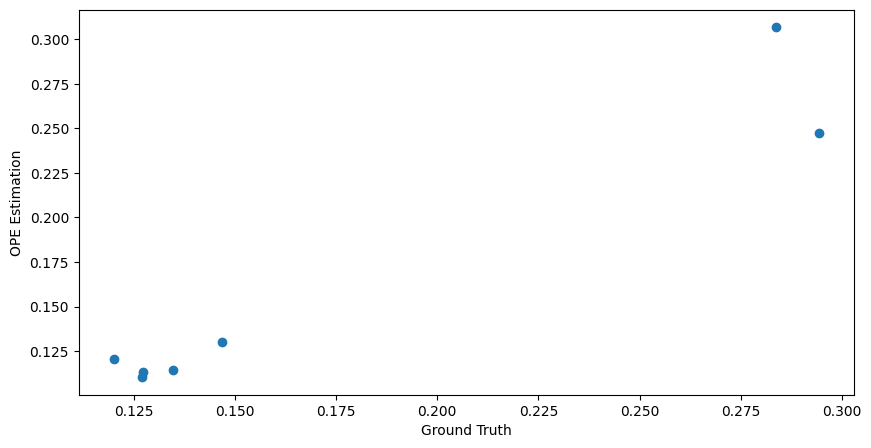

In [25]:
# plot the new means (x) vs the original means (y)
plt.figure(figsize=(10, 5))
plt.plot(original_means, new_means, 'o')
plt.xlabel("Ground Truth")
plt.ylabel("OPE Estimation")


Text(0, 0.5, 'OPE Estimation')

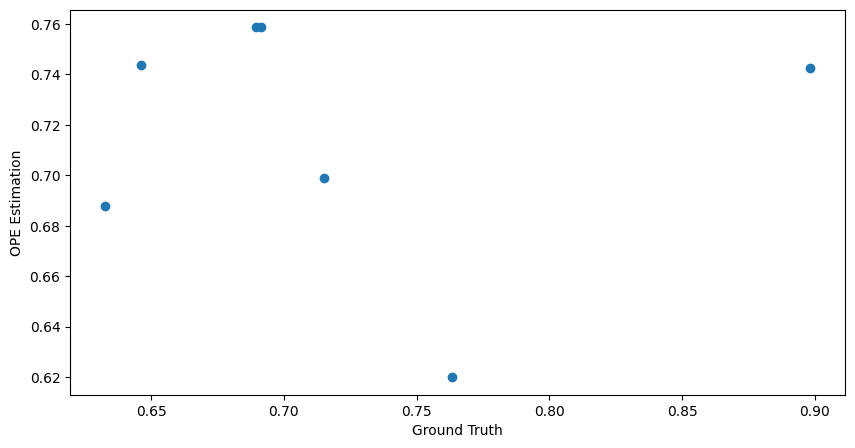

In [13]:
# plot the new means (x) vs the original means (y)
plt.figure(figsize=(10, 5))
plt.plot(original_means, new_means, 'o')
plt.xlabel("Ground Truth")
plt.ylabel("OPE Estimation")


# plot the 